In [60]:
import pickle
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import requests
from PIL import Image


# Step 1: Load the dataset
with open('data/dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

Shape: (8, 256, 256, 3)
Data type: uint8


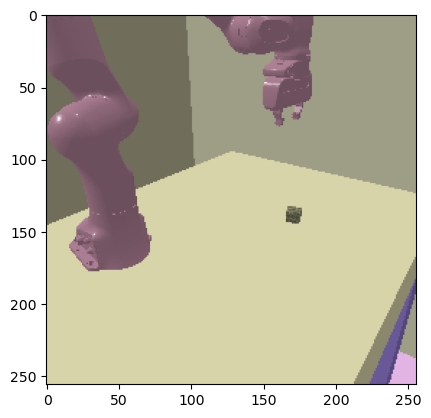

In [47]:
image_data = np.array(dataset["episode_0"][0]["observation"]["front_image"])

print("Shape:", image_data.shape)
print("Data type:", image_data.dtype)

first_image = image_data[0]

# display the first image inline in the notebook
%matplotlib inline

plt.imshow(first_image)


In [120]:

# Step 2: Preprocess the images to extract edges
edges_dataset = []
for episode in dataset.values():
    for observation in episode:
        images = observation["observation"]["front_image"]
        for image in images:
            edges = cv2.Canny(image, 50, 150) # These parameters are: (img, minVal, maxVal), the values refer to the intensity of the edges
            edges = edges[:,:,None]
            edges = np.concatenate([edges, edges, edges], axis=2)
            edges = Image.fromarray(edges)
            edges_dataset.append(edges)

print("Shape:", edges_dataset[0])

Shape: <PIL.Image.Image image mode=RGB size=256x256 at 0x7F1787E501C0>


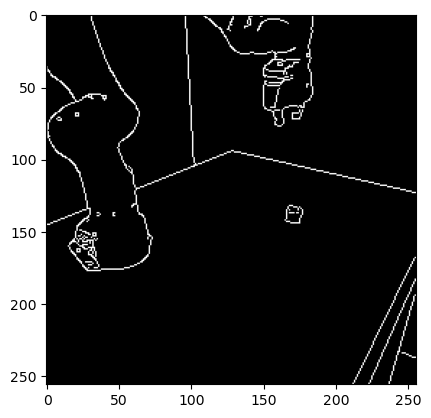

In [77]:
plt.imshow(edges_dataset[0])

In [22]:
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline.to(device)


























































































































































































































































































































































































































































































































































































































































































































































































































































































Fetching 15 files:  27%|██▋       | 4/15 [04:18<12:48, 69.90s/it]















































































StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 40/40 [00:01<00:00, 22.78it/s]


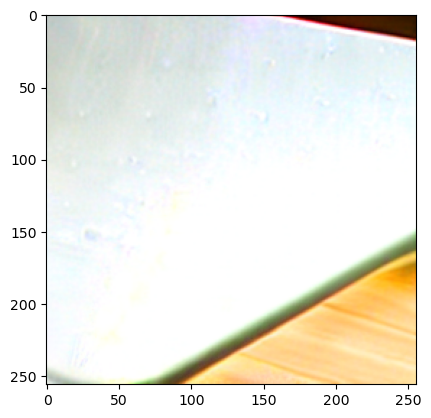

In [50]:
# Step 3: Create image from edges
prompt = "A realistic robotic arm on a table in a lab, grabing an object"

result = pipeline(prompt = prompt, image = first_image, strength=0.8, guidance_scale=20)


plt.imshow(result[0][0])

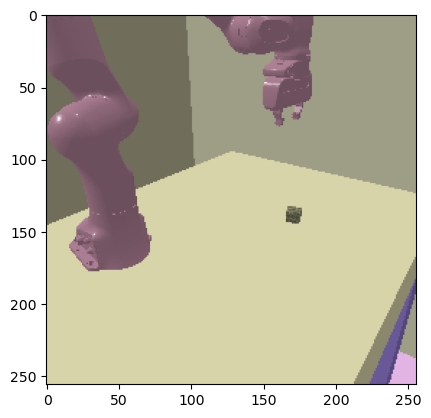

In [49]:
plt.imshow(first_image)

In [54]:
# https://huggingface.co/lllyasviel/sd-controlnet-canny

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 5.80 GiB of which 3.69 MiB is free. Including non-PyTorch memory, this process has 5.78 GiB memory in use. Of the allocated memory 5.62 GiB is allocated by PyTorch, and 16.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [70]:
# empty cuda 
torch.cuda.empty_cache()

pipeline.to("cpu")
pipe.to(device)
pipe.enable_model_cpu_offload()
torch.backends.cuda.preferred_linalg_library('magma')

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

<_LinalgBackend.Magma: 2>

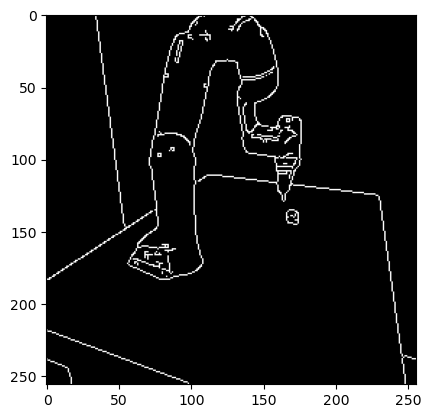

In [80]:
plt.imshow(edges_dataset[20])

  5%|▌         | 1/20 [00:00<00:11,  1.72it/s]CUBLAS error: out of memory (3) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: not initialized (1) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: memory mapping error (11) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:149
 15%|█▌        | 3/20 [00:00<00:03,  5.03it/s]CUBLAS error: out of memory (3) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: not initialized (1) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: memory mapping error (11) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:149
CUBLAS error: out of memory (3) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_169180

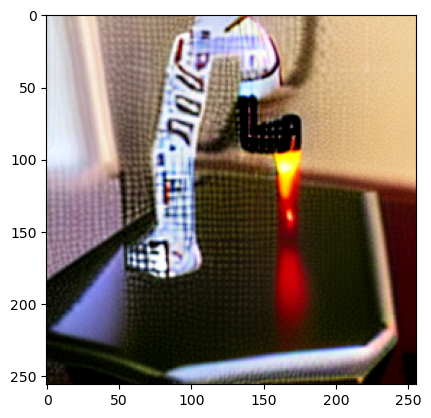

In [88]:
prompt = "Robotic arm anchored to a table in a lab and an object on the table. Trending on artstation."

image = pipe(prompt, edges_dataset[20], num_inference_steps=20).images[0]
plt.imshow(image)

In [93]:
from diffusers.utils import load_image

image = load_image("bird.png")
image = np.array(image)

low_threshold = 100
high_threshold = 200

ima = cv2.Canny(image, low_threshold, high_threshold)
ima = ima[:, :, None]
ima = np.concatenate([ima, ima, ima], axis=2)
ima = Image.fromarray(ima)

print(ima)

image = pipe("bird", ima, num_inference_steps=20).images[0]

<PIL.Image.Image image mode=RGB size=564x846 at 0x7F17C3B61C30>


 10%|█         | 2/20 [00:01<00:10,  1.80it/s]CUBLAS error: out of memory (3) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: not initialized (1) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: memory mapping error (11) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:149
 15%|█▌        | 3/20 [00:01<00:07,  2.22it/s]CUBLAS error: out of memory (3) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: not initialized (1) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:118
CUBLAS error: memory mapping error (11) in magma_sgetrs_gpu at /opt/conda/conda-bld/magma-cuda121_1691801004277/work/src/sgetrs_gpu.cpp:149
 20%|██        | 4/20 [00:01<00:06,  2.50it/s]CUBLAS error: out of memory (3) in magma_sgetrs_gp

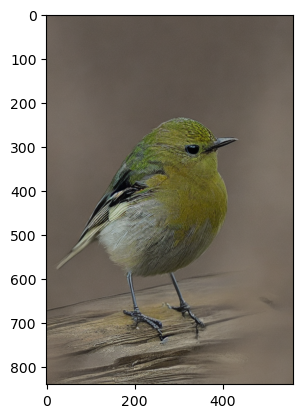

In [94]:
plt.imshow(image)

In [97]:
# https://huggingface.co/lllyasviel/sd-controlnet-mlsd

# remove current model from cache
# del pipe 
torch.cuda.empty_cache()

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector

mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()


Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


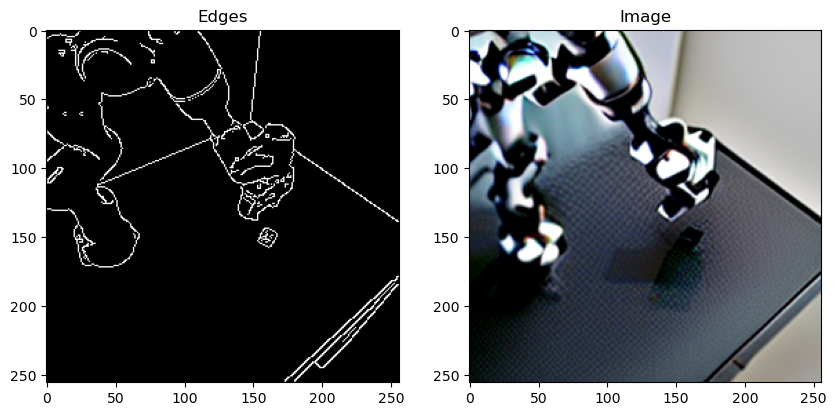

In [162]:
prompt = "Realistic grey robotic arm anchored to a white table and a small object on the table. White plain background and soft lighting."
edge = edges_dataset[17]

image = pipe(prompt, edge, num_inference_steps=20).images[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(edge)
plt.title('Edges')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Image')

plt.show()